In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: In order to compute the dependency simmilarity CoreNLP is required:
# Function to start CoreNLP service.
# java -mx4g -cp C:\stanford-corenlp-full-2018-10-05\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

import nltk
import numpy 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from nltk.corpus import brown, movie_reviews, treebank


from similarities import * 
from features import * 
from utils import *

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [92]:
# Load SemEval training datasets from 2012 to 2017
X_train, X_val, X_test = load_dataset()
# Load SemEval 2012 validation set
X_gs = load_gold_standard_dataset()

# Joint training datasets into single dataframe
X_all = pandas.DataFrame(X_train)
X_all = X_all.append(X_test)
X_all = X_all.append(X_val)
X_all.reset_index(inplace=True)
X_all.drop(columns=['index'], inplace=True)

# Create target vectors 
y_all_target = X_all['Label'].values
y_gs_target = X_gs['Label'].values

X_all[:5]

Training set  (13365, 3)
Validation set  (1500, 3)
Test set  (250, 3)
Gold standard set contains (2358, 2) sentences
Gold standard set contains (2358, 1) labeles


,S1,S2,Label
0,umm the california was a cargo ship i dont car...,the california was a cargo ship,4.0
1,how can i prepare this old exterior wall for p...,how do i prepare this exterior concrete wall f...,4.0
2,the man is playing the guitar,a man is playing guitar,5.0
3,it was a final test before delivering the mis...,state radio said it was the last test before t...,4.0
4,this does not fully answer your question but ...,i am a phd student in computational science w...,0.0


# Compute features for each dataset partition

In [3]:
def compute_features(source):
    """
    This function computes all the developed features and metrics and stores them as single columns in the original 
    dataframe.
    """
    for index, db_entry in source.iterrows():
        s1 = db_entry['S1']
        s2 = db_entry['S2'] 
        # Compute all features
#         source.at[index, 'jacc'] = jaccard_similarity(s1, s2)
        source.at[index, 'jacc-lemm'] = lemmas_similarity(s1, s2, filter_stop_words=True)
        source.at[index, 'jacc-lemm-sw'] = lemmas_similarity(s1, s2, filter_stop_words=False)
#         source.at[index, 'ne-sim'] = ne_simmilarity(s1, s2)
        sim_n2, sim_n3, sim_n4 = ngrams_similarity(s1, s2, filter_stop_words=False)
        source.at[index, 'ngram2-sw'] = sim_n2
        source.at[index, 'ngram3-sw'] = sim_n3 
        source.at[index, 'ngram4-sw'] = sim_n4 
        sim_n2, sim_n3, sim_n4 = ngrams_similarity(s1, s2, filter_stop_words=True)
        source.at[index, 'ngram2'] = sim_n2
        source.at[index, 'ngram3'] = sim_n3
        source.at[index, 'ngram4'] = sim_n4
        source.at[index, 'info'] = information_content_similarity(s1, s2)
        source.at[index, 'glove-mean'] = glove_word2vec_vec_similarity(s1, s2)
        source.at[index, 'jaro-winkler'] = pyjarowinkler_distance(s1,s2)
        source.at[index, 'edit-distance'] = edit_distance(s1,s2)
        lc_word, lc_lemm = simple_baseline_similarity(s1, s2)
#         source.at[index, 'lcs-word'] = lc_word
        source.at[index, 'lcs-lemm'] = lc_lemm
        source.at[index, 'depend'] = dependency_similarity(s1, s2)
        source.at[index, 'synset'] = synsets_similarity(s1, s2)
        source.at[index, 'lcs'] = longest_common_subsequence(s1, s2)
        source.at[index, 'overlap'] = extract_overlap_pen(s1, s2)
        all_comm, adj_comm, adv_comm, noun_comm, verb_comm = extract_absolute_difference(s1, s2)
        source.at[index, 'all_comm'] = all_comm
        source.at[index, 'adj_comm'] = adj_comm
        source.at[index, 'adv_comm'] = adv_comm
        source.at[index, 'noun_comm'] = noun_comm
        source.at[index, 'verb_comm'] = verb_comm


In [9]:
%%time
compute_features(source = X_all)
X_all.to_csv('processed_data/X_all.csv', sep='\t')

Wall time: 825 ms


In [8]:
%%time
compute_features(source = X_gs)
X_gs.to_csv('processed_data/X_gs.csv', sep='\t')
X_gs[:5]

Wall time: 216 ms


,Unnamed: 0,S1,S2,Label,jacc,jacc-lemm,jacc-lemm-sw,ngram2-sw,ngram3-sw,ngram4-sw,...,synset,overlap,all_comm,adj_comm,adv_comm,noun_comm,verb_comm,bow,lcs,bow-rfr
0,0,A man with a hard hat is dancing,A man wearing a hard hat is dancing,5.00,0.750000,0.750000,0.800000,0.555556,0.333333,0.250000,...,0.800000,0.888790,0.000000,0.0,0.0,0.000000,0.2,3.669450,1.0,3.169310
1,1,A plane is taking off,An air plane is taking off,5.00,0.571429,0.571429,0.666667,0.500000,0.400000,0.250000,...,0.666667,0.799840,0.090909,0.0,0.0,0.333333,0.0,3.253023,1.0,3.514320
2,2,A young child is riding a horse,A child is riding a horse,4.75,0.833333,0.833333,0.750000,0.571429,0.500000,0.400000,...,0.400000,0.857020,0.076923,1.0,0.0,0.000000,0.0,3.363795,1.0,2.897000
3,3,A man is feeding a mouse to a snake,The man is feeding a mouse to the snake,5.00,0.875000,0.875000,1.000000,0.454545,0.400000,0.333333,...,1.000000,0.999875,0.000000,0.0,0.0,0.000000,0.0,4.018925,1.0,3.145530
4,4,A man is playing a large flute,A man is playing a flute,3.80,0.833333,0.833333,0.750000,0.571429,0.500000,0.400000,...,0.750000,0.857020,0.076923,1.0,0.0,0.000000,0.0,4.158715,1.0,2.687925


# Load precomputed dataset partition features 

In case you have not added any new feature, avoid computing them again and just load the pre-processed ones.

In [4]:
X_all = pandas.read_csv('processed_data/X_all.csv', sep='\t')
X_gs = pandas.read_csv('processed_data/X_gs.csv', sep='\t')
print("All (Train): ", X_all.shape, " GS: ", X_gs.shape)

y_all_target = X_all['Label'].values
y_gs_target = X_gs['Label'].values

def calculate_pearson_corr(model, features, model_name):
    y_all_pred = model.predict(X_all[features].values)
    y_gs_pred = model.predict(X_gs[features].values)

    correlation = pearsonr(list(y_all_target), list(y_all_pred))[0]
    print("\n %s Correlation on Train set: %.4f" % (model_name, correlation))
    correlation = pearsonr(list(y_gs_target), list(y_gs_pred))[0]
    print("\n %s Correlation on Gold-Standard set: %.4f" % (model_name, correlation))
    
X_all[:5]

All (Train):  (15115, 28)  GS:  (2358, 28)


,Unnamed: 0,S1,S2,Label,jacc,jacc-lemm,jacc-lemm-sw,ngram2-sw,ngram3-sw,ngram4-sw,...,depend,synset,overlap,all_comm,adj_comm,adv_comm,noun_comm,verb_comm,bow,lcs
0,0,umm the california was a cargo ship i dont car...,the california was a cargo ship,4.0,0.461538,0.461538,0.375000,0.384615,0.333333,0.272727,...,0.384615,0.333333,0.599940,0.400000,1.0,0.0,0.250000,0.50,3.479829,1.000000
1,1,how can i prepare this old exterior wall for p...,how do i prepare this exterior concrete wall f...,4.0,0.538462,0.666667,0.428571,0.200000,0.066667,0.000000,...,0.285714,0.250000,0.799920,0.000000,0.0,1.0,0.200000,0.20,3.921753,0.870968
2,2,the man is playing the guitar,a man is playing guitar,5.0,0.666667,0.666667,1.000000,0.285714,0.166667,0.000000,...,0.500000,1.000000,0.999833,0.090909,0.0,0.0,0.000000,0.00,3.849185,1.000000
3,3,it was a final test before delivering the mis...,state radio said it was the last test before t...,4.0,0.529412,0.625000,0.500000,0.272727,0.083333,0.043478,...,0.272727,0.500000,0.666622,0.133333,0.0,0.0,0.250000,0.25,3.398363,0.722222
4,4,this does not fully answer your question but ...,i am a phd student in computational science w...,0.0,0.033333,0.034483,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.187500,1.0,1.0,0.555556,0.00,1.024222,0.555556


___________________________________
# Generate Bag of Words with tf/Idf features.

In this block we create the normalized bag of words features with Tf/idf, and use them to train two Ensemble methods.  

In [5]:
# Create document as the combination of all training sentences.
combined_training = X_all['S1'] + X_all['S2']
combined_gs = X_gs['S1'] + X_gs['S2']

# Create bag of words Model
bow_model = CountVectorizer(lowercase=False, analyzer=lambda x: x)
# Create bag of words of training  and GS set 
bow_X_train = bow_model.fit_transform(combined_training)
bow_X_gs = bow_model.transform(combined_gs)
# Aplly Tf/Idf transformation of the bag of words
tfidf_model = TfidfTransformer()
# Obtain feature vector for each sentence pair
tfidf_X_train = tfidf_model.fit_transform(bow_X_train)
tfidf_X_gs = tfidf_model.transform(bow_X_gs)

In [6]:
# Use Tf/Idf feature vectors for regression with Gradient Boosting Regressor 
# GBR is used here considering that the training dataset contains sentence pairs from different 
# datasets, contexts and general topics. For this reason an Ensemble method might outperform single models 
gbr_bow_model = GradientBoostingRegressor(n_estimators=5000)
gbr_bow_model.fit(tfidf_X_train, y_all_target)

# Generate prediction 
y_gs_pred = gbr_bow_model.predict(tfidf_X_gs)
y_train_pred = gbr_bow_model.predict(tfidf_X_train)

# Compute its correlation 
correlation = pearsonr(list(y_gs_target), list(y_gs_pred))[0]
print("Bag of words with tf/idf correlation on Gold-Standard set: %.4f" % (correlation))
correlation = pearsonr(list(y_all_target), list(y_train_pred))[0]
print("Bag of words with tf/idf correlation on Training set: %.4f" % (correlation))

# Save predictions as features
X_all['bow'] = y_train_pred
X_gs['bow'] = y_gs_pred

Bag of words with tf/idf correlation on Gold-Standard set: 0.6198
Bag of words with tf/idf correlation on Training set: 0.9458


In [7]:
# Use Tf/Idf feature vectors for regression with Random Forest Regressor
# RFR is used here considering that the training dataset contains sentence pairs from different 
# datasets, contexts and general topics. For this reason an Ensemble method might outperform single models 
rfr_bow_model = RandomForestRegressor(n_estimators=100)
rfr_bow_model.fit(tfidf_X_train, y_all_target)

y_gs_rf_pred = rfr_bow_model.predict(tfidf_X_gs)
y_train_rf_pred = rfr_bow_model.predict(tfidf_X_train)

correlation = pearsonr(list(y_gs_target), list(y_gs_rf_pred))[0]
print("Bag of words with tf/idf (RFR) correlation on Gold-Standard set: %.4f" % (correlation))
correlation = pearsonr(list(y_all_target), list(y_train_rf_pred))[0]
print("Bag of words with tf/idf (RFR) correlation on Train set: %.4f" % (correlation))

# Save predictions as features
X_all['bow-rfr'] = y_train_rf_pred
X_gs['bow-rfr'] = y_gs_rf_pred

print("\nRanfom Forest trained with feature vectors of %d dimensions" % tfidf_X_gs[0].shape[1])

Bag of words with tf/idf (RFR) correlation on Gold-Standard set: 0.7902
Bag of words with tf/idf (RFR) correlation on Train set: 0.9780

Ranfom Forest trained with feature vectors of 94 dimensions


____________________________________
# Evaluate pearson correlation per-feature and select best bunch

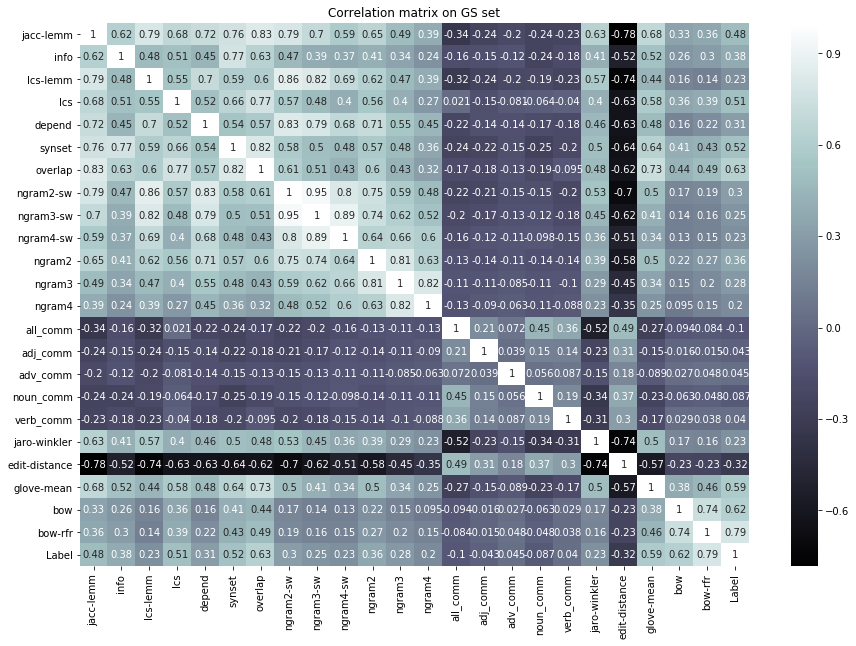

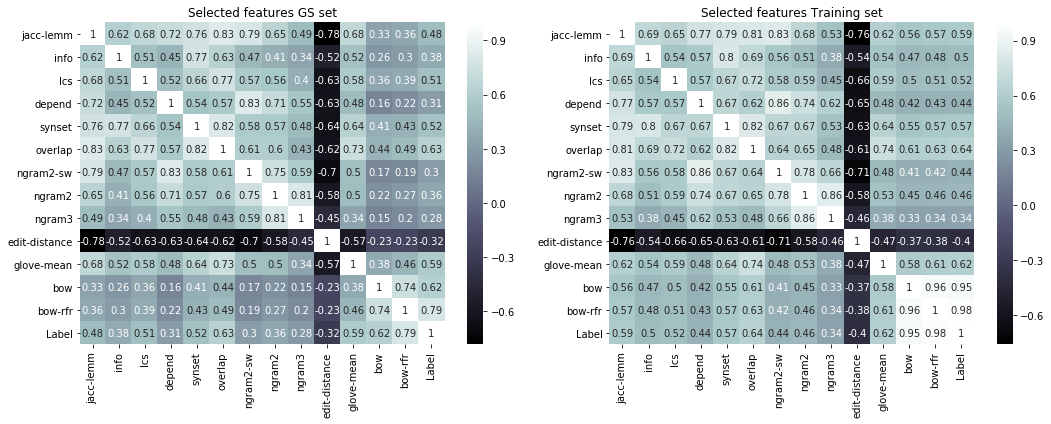

Relevant Features:
 jacc-lemm        0.484731
info             0.381876
lcs              0.507088
depend           0.305950
synset           0.522957
overlap          0.625733
ngram2-sw        0.304033
ngram2           0.363391
ngram3           0.275386
edit-distance    0.320958
glove-mean       0.587105
bow              0.619848
bow-rfr          0.790245
Label            1.000000
Name: Label, dtype: float64


In [10]:
features = ['jacc-lemm', 'info', 'lcs-lemm', 'lcs', 'depend', 'synset', 'overlap', 'ngram2-sw', 'ngram3-sw', 'ngram4-sw',
            'ngram2', 'ngram3', 'ngram4', 'all_comm', 'adj_comm', 'adv_comm', 'noun_comm', 'verb_comm', 'jaro-winkler', 
            'edit-distance', 'glove-mean', 'bow', 'bow-rfr']

dataframe = X_gs
cor = dataframe[features + ['Label']].corr()
plt.figure(figsize=(15,10))
plt.title("Correlation matrix on GS set")
sns.heatmap(cor, annot=True, cmap=plt.cm.bone)
plt.show()

#Correlation with output variable
cor_target = abs(cor["Label"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25]

cor = dataframe[list(relevant_features.index)].corr()
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title("Selected features GS set")
sns.heatmap(cor, annot=True, cmap=plt.cm.bone)

cor = X_all[list(relevant_features.index)].corr()
plt.subplot(122)
plt.title("Selected features Training set")
sns.heatmap(cor, annot=True, cmap=plt.cm.bone)
plt.tight_layout()
plt.show()
# print(list(relevant_features.index))
print("Relevant Features:\n", relevant_features)

In [12]:
len(list(relevant_features.index))

14

Once we have the features and a certain knowledge of which of them are relevant we test different models on them.
_________________________
#  Model: Linear regression

This block shows the performance of linear regression with multiple feature sets, generated by the Recursive Feature Elimination algorithm. 

Optimum number of features: 12
Selected features: 
 ['jacc-lemm' 'info' 'lcs' 'depend' 'synset' 'overlap' 'ngram2-sw' 'ngram2'
 'ngram3' 'glove-mean' 'bow' 'bow-rfr']


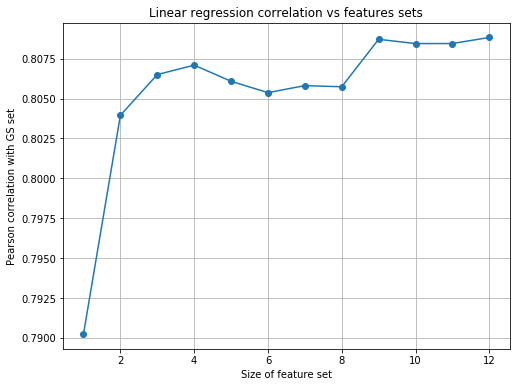


 Linear Regression Correlation on Train set: 0.9797

 Linear Regression Correlation on Gold-Standard set: 0.8088


In [30]:
features = list(relevant_features.index.drop(['Label']))
#no of features
features_vec = numpy.array(features)
best_features = numpy.array(features)
nof_list = numpy.arange(1,len(features), dtype=numpy.short)            
high_score = 0
#Variable to store the optimum features
nof=0           
score_list =[]
# Model to evaluate 
lin_reg_model = LinearRegression(normalize=True)

# Search or optimal number of features.
for n in range(len(nof_list)):
    rfe = RFE(lin_reg_model, nof_list[n])
    # Filter out features from dataset
    X_all_rfe = rfe.fit_transform(X_all[features].values, y_all_target)
    X_gs_rfe = rfe.transform(X_gs[features].values)
    # Predict lin_reg_model outcome with the selected features
    lin_reg_model.fit(X_all_rfe,y_all_target)
    y_all_pred = lin_reg_model.predict(X_all_rfe)
    y_gs_pred = lin_reg_model.predict(X_gs_rfe)
    # Evaluate model performance 
    score = pearsonr(list(X_gs['Label']), list(y_gs_pred))[0]
    score_list.append(score)
    
    sel_features_ids = rfe.get_support(indices=True)
    # print("Num of Features: %d - Corr: %.5f" % (nof_list[n], score))
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        best_features = features_vec[rfe.get_support(indices=True)]


# Show results

print("Optimum number of features: %d" %nof)
print("Selected features: \n %s" % best_features)

plt.figure(figsize=(8,6))
plt.plot(nof_list, score_list, '-o')
plt.title("Linear regression correlation vs features sets")
plt.ylabel("Pearson correlation with GS set")
plt.xlabel("Size of feature set")
plt.grid()
plt.show()


# Predict labels for all dataset partitions with selected features 
lin_reg_model.fit(X_all[best_features].values,y_all_target)

calculate_pearson_corr(model=lin_reg_model, features=best_features, model_name="Linear Regression")

_______________________________________
# Model: Support Vector Regression (SVM)

This block shows the performance of a Support Vector Regression model on the different datasets partitioning, considering only the selected features from the previous section.

In [ ]:
parameters = {'kernel':('poly', 'rbf', 'sigmoid'), 
             'C':[1, 2],
             'epsilon':numpy.linspace(0.08,0.4,5)}

svr = SVR(gamma='scale')
clf = GridSearchCV(svr, parameters, cv=5, verbose=0)
clf.fit(X_train[features], y_train_target)
# Best params:  {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'} -> GS: 0.6154
# Best params:  {'C': 2, 'epsilon': 0.4, 'kernel': 'rbf'} -> GS: 0.6185
print("Best params: ", clf.best_params_)
svr_model = clf.best_estimator_

In [31]:
##### %%time 

svr_model = SVR(gamma='scale',C=2, epsilon=0.4, kernel='rbf')
svr_model.fit(X_all[features], y_all_target)

# Predict labels for all dataset partitions 
calculate_pearson_corr(model=svr_model, features=features, model_name="SVR")


 SVR Correlation on Train set: 0.9854

 SVR Correlation on Gold-Standard set: 0.8195


_____________________________________________________
# Model: Multi Layer Perceptron (1 Hidden Layer)

This block shows the performance of a single hidden layer multi-layer-perceptron model on the different dataset partitions. A grid search for the best hyper parameters of the model (size of units, learning rate, activation function)

In [33]:
# lr 0.01 HD:200 -> 0.6119
# lr 0.1 HD:290 	 Act:elu  	 Corr:0.62666
# - HD:500 	 Act:elu  	 lr:0.056 	 Corr:0.63267

def build_model(hidden, activation='relu', lr=0.01):
    
    hidden_layers = [layers.Dense(units=hd, activation=activation) for hd in hidden]
    model = keras.Sequential(hidden_layers + [layers.Dense(1)])
    optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

# Define early stopping metric
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

mlp_model = None
best_hist = None
best_corr = 0
best_model_params = None


Epoch: 0, loss:2.4891,  mae:1.2620,  mse:2.4891,  val_loss:1.8905,  val_mae:1.1803,  val_mse:1.8905,  
....................................................................................................
Epoch: 100, loss:1.1043,  mae:0.8316,  mse:1.1043,  val_loss:1.2609,  val_mae:0.8946,  val_mse:1.2609,  
................................
- HD:100 	 Act:relu  	 lr:0.001 	 Corr:0.74009

Epoch: 0, loss:1.4385,  mae:0.9767,  mse:1.4385,  val_loss:1.2398,  val_mae:0.9138,  val_mse:1.2398,  
..................................................................................
- HD:100 	 Act:relu  	 lr:0.012 	 Corr:0.72741

Epoch: 0, loss:1.4300,  mae:0.9773,  mse:1.4300,  val_loss:1.8515,  val_mae:1.1439,  val_mse:1.8515,  
....................................................................................................
Epoch: 100, loss:1.1412,  mae:0.8479,  mse:1.1412,  val_loss:1.1305,  val_mae:0.8365,  val_mse:1.1305,  
..................................................................

.........................................................................................
- HD:150 	 Act:relu  	 lr:0.045 	 Corr:0.69754

Epoch: 0, loss:1.5087,  mae:0.9969,  mse:1.5087,  val_loss:2.1509,  val_mae:1.2852,  val_mse:2.1509,  
..............................................................
- HD:150 	 Act:relu  	 lr:0.056 	 Corr:0.66118

Epoch: 0, loss:1.4618,  mae:0.9902,  mse:1.4618,  val_loss:2.2992,  val_mae:1.3315,  val_mse:2.2992,  
....................................................................................................
Epoch: 100, loss:1.1827,  mae:0.8663,  mse:1.1827,  val_loss:1.3480,  val_mae:0.9640,  val_mse:1.3480,  
..................
- HD:150 	 Act:relu  	 lr:0.067 	 Corr:0.71469

Epoch: 0, loss:1.4493,  mae:0.9863,  mse:1.4493,  val_loss:1.6129,  val_mae:1.0469,  val_mse:1.6129,  
......................................................
- HD:150 	 Act:relu  	 lr:0.078 	 Corr:0.65999

Epoch: 0, loss:1.5553,  mae:1.0133,  mse:1.5553,  val_loss:2.0130,

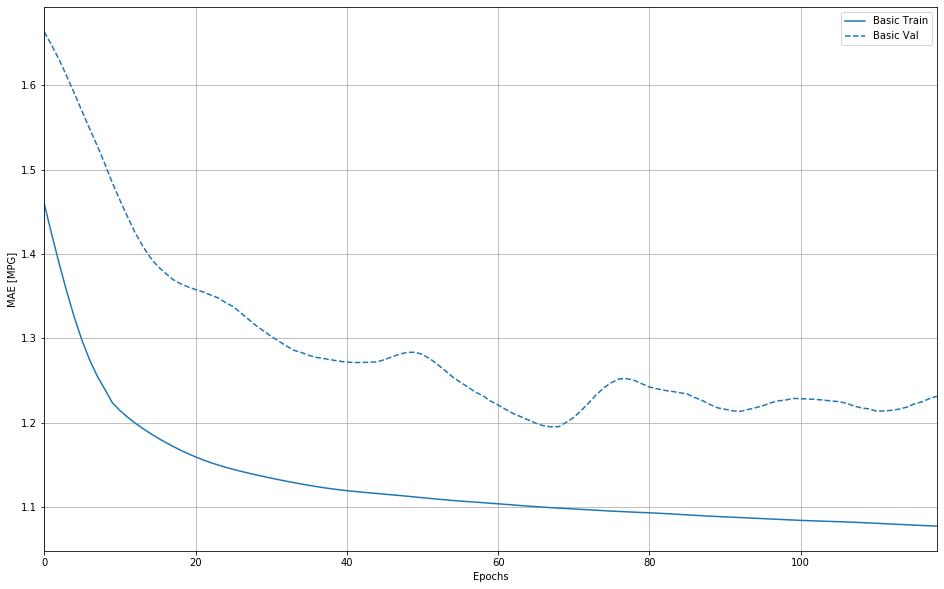

In [17]:
features = ['jacc-lemm', 'info', 'lcs', 'depend', 'synset', 'overlap', 'ngram2-sw', 'ngram2',
 'edit-distance', 'glove-mean']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_centered = scaler.fit_transform(X_all[features])

# Finde best MLP model 
for hd in numpy.linspace(100, 200, 3):    
    for activation in ['relu', 'elu']:
        for lr in numpy.linspace(0.0005, 0.1, 10):
            model = build_model([hd], activation=activation, lr=lr)
            EPOCHS = 500
            history = model.fit(x=X_train_centered, 
                                y=y_all_target, 
                                epochs=EPOCHS, 
#                                 validation_split = 0.2,
                                validation_data=(scaler.transform(X_gs[features].values), y_gs_target),
                                shuffle=True,
                                verbose=0,
                                callbacks=[early_stop, tfdocs.modeling.EpochDots()])

            y_gs_pred = model.predict(scaler.transform(X_gs[features].values)).flatten()
            correlation = pearsonr(list(X_gs['Label']), list(y_gs_pred))[0]

            print("\n- HD:%d \t Act:%s  \t lr:%.3f \t Corr:%.5f" % (hd, activation, lr, correlation))
            if correlation > best_corr:
                best_corr = correlation
                mlp_model = model
                best_hist = history
                best_model_params = (hd, activation, lr, correlation)
    
mlp_model.summary()
mlp_model.save("models\MLP-1HL_v2",
                overwrite=True,
                include_optimizer=True)

print("\n\n Best Model params: \n - HD:%d \t Act:%s  \t lr:%.3f \t Corr:%.5f" % best_model_params)
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': best_hist}, metric = "mse")
# plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.show()

In [18]:
# - HD:150 	 Act:relu  	 lr:0.001 	 Corr:0.74457
if mlp_model is None:
#     mlp_model = tf.keras.models.load_model("models\MLP-1HL")
    mlp_model = tf.keras.models.load_model("models\MLP-1HL_v2")

# Predict labels for all dataset partitions 
y_mlp_train_pred = mlp_model.predict(scaler.transform(X_all[features].values)).flatten()
y_mlp_gs_pred = mlp_model.predict(scaler.transform(X_gs[features].values)).flatten()

correlation = pearsonr(list(y_all_target), list(y_mlp_train_pred))[0]
print("\n MLP Correlation on Train set: %.4f" % correlation)
correlation = pearsonr(list(y_gs_target), list(y_mlp_gs_pred))[0]
print("\n MLP Correlation on Gold-Standard set: %.4f" % correlation)


 MLP Correlation on Train set: 0.7516

 MLP Correlation on Gold-Standard set: 0.7455


### Now lets test the MLP performance with the BoW features.

In [37]:
# - HD:150 	 Act:relu  	 lr:0.001 	 Corr:0.74457

features = list(relevant_features.index.drop(['Label']))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_centered = scaler.fit_transform(X_all[features])

# Test model with BoW features 
mlp_model = build_model([150], activation='relu', lr=0.001)
EPOCHS = 500
history = mlp_model.fit(x=X_train_centered, 
                    y=y_all_target, 
                    epochs=EPOCHS, 
#                                 validation_split = 0.2,
                    validation_data=(scaler.transform(X_gs[features].values), y_gs_target),
                    shuffle=True,
                    verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

# Predict labels for all dataset partitions 
y_mlp_train_pred = mlp_model.predict(scaler.transform(X_all[features].values)).flatten()
y_mlp_gs_pred = mlp_model.predict(scaler.transform(X_gs[features].values)).flatten()

correlation = pearsonr(list(y_all_target), list(y_mlp_train_pred))[0]
print("\n MLP Correlation on Train set: %.4f" % correlation)
correlation = pearsonr(list(y_gs_target), list(y_mlp_gs_pred))[0]
print("\n MLP Correlation on Gold-Standard set: %.4f" % correlation)


Epoch: 0, loss:0.8910,  mae:0.6277,  mse:0.8910,  val_loss:0.9059,  val_mae:0.7524,  val_mse:0.9059,  
....................................................................................................
Epoch: 100, loss:0.0685,  mae:0.2036,  mse:0.0685,  val_loss:0.8285,  val_mae:0.6905,  val_mse:0.8285,  
...............
 MLP Correlation on Train set: 0.9866

 MLP Correlation on Gold-Standard set: 0.8092


# Gradient Boosting Regressor  (Best Model)

This block shows the performance of the GBR model using the relvant features sets with and without the BoW features.

Initially we use Recursive Feature Elimination to determine the set of features that best perform with the system.

Checking performance with 2 features
Checking performance with 3 features
Checking performance with 4 features
Checking performance with 5 features
Checking performance with 6 features
Checking performance with 7 features
Checking performance with 8 features
Checking performance with 9 features
Optimum number of features: 8
Selected features: 
 ['jacc-lemm' 'info' 'lcs' 'synset' 'overlap' 'ngram2-sw' 'edit-distance'
 'glove-mean']


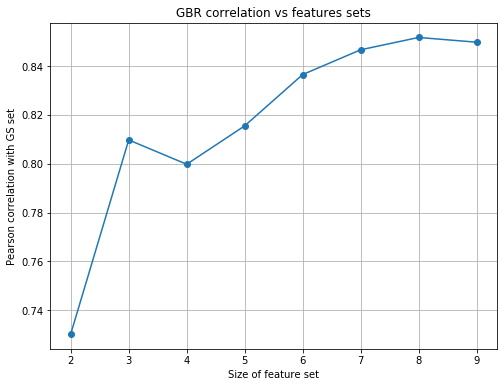

In [17]:
#no of features
features = ['jacc-lemm', 'info', 'lcs', 'depend', 'synset', 'overlap', 'ngram2-sw', 'ngram2',
 'edit-distance', 'glove-mean']
features_vec = numpy.array(features)
best_features = numpy.array(features)
nof_list = numpy.arange(2,len(features), dtype=numpy.short)            
high_score = 0
#Variable to store the optimum features
nof=0           
score_list =[]
# Model to evaluate 
params = {'n_estimators': 1500, 'max_depth': 4, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)

# Search or optimal number of features.
for n in range(len(nof_list)):
    print("Checking performance with %d features" % (nof_list[n]))
    rfe = RFE(gbr, nof_list[n])
    # Filter out features from dataset
    X_all_rfe = rfe.fit_transform(X_all[features].values, y_all_target)
    X_gs_rfe = rfe.transform(X_gs[features].values)
    # Predict gbr outcome with the selected features
    gbr.fit(X_all_rfe,y_all_target)
    y_all_pred = gbr.predict(X_all_rfe)
    y_gs_pred = gbr.predict(X_gs_rfe)
    # Evaluate model performance 
    score = pearsonr(list(X_gs['Label']), list(y_gs_pred))[0]
    score_list.append(score)
    
    sel_features_ids = rfe.get_support(indices=True)
    # print("Num of Features: %d - Corr: %.5f" % (nof_list[n], score))
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        best_features = features_vec[rfe.get_support(indices=True)]
# _____________________________________________________________________________
print("Optimum number of features: %d" %nof)
print("Selected features: \n %s" % best_features)

plt.figure(figsize=(8,6))
plt.plot(nof_list, score_list, '-o')
plt.title("GBR correlation vs features sets")
plt.ylabel("Pearson correlation with GS set")
plt.xlabel("Size of feature set")
plt.grid()
plt.show()


Then we re-train the model with more boosting iterations.


 Gradient Boosting Regressor Correlation on Train set: 0.9992

 Gradient Boosting Regressor Correlation on Gold-Standard set: 0.9053


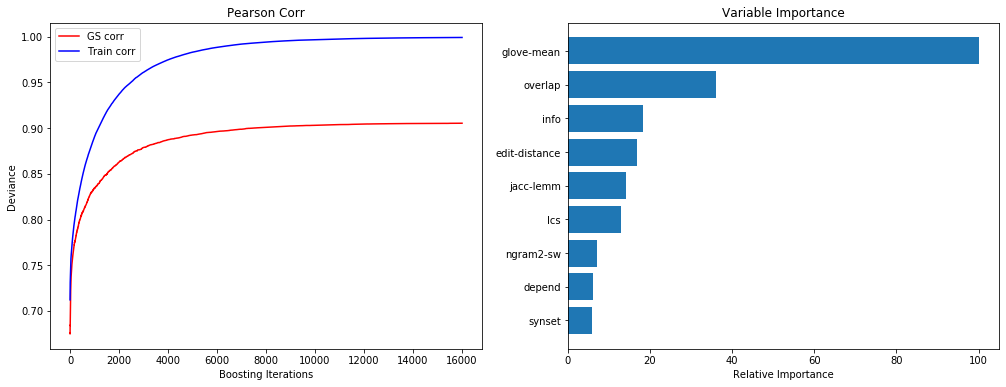

In [39]:
# Select the best features for Gradient Boosting Regressor 
best_features =  ['jacc-lemm', 'info', 'lcs', 'depend', 'synset', 'overlap', 'ngram2-sw', 'edit-distance', 'glove-mean']

# Train the model
params = {'n_estimators': 16000, 'max_depth': 4, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_all[best_features].values, y_all_target)

y_gs_gbr_pred = gbr.predict(X_gs[best_features])
y_all_gbr_pred = gbr.predict(X_all[best_features])

# Evaluate model performance 
calculate_pearson_corr(model=gbr, features=best_features, model_name="Gradient Boosting Regressor")

# Plot training correlation
test_score = numpy.zeros((params['n_estimators'],), dtype=numpy.float64)
train_score = numpy.zeros((params['n_estimators'],), dtype=numpy.float64)

for i, y_gs_pred in enumerate(gbr.staged_predict(X_gs[best_features])):
    test_score[i] = pearsonr(list(y_gs_target), list(y_gs_pred))[0]
for i, y_all_pred in enumerate(gbr.staged_predict(X_all[best_features])):
    train_score[i] = pearsonr(list(y_all_target), list(y_all_pred))[0]

plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.title('Pearson Corr')
plt.plot(numpy.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='GS corr')
plt.plot(numpy.arange(params['n_estimators']) + 1, train_score, 'b-',
         label='Train corr')
plt.legend()
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = numpy.argsort(feature_importance)
features_vec = numpy.array(best_features)
pos = numpy.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features_vec[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


### Now lets test the GBR performance with the BoW features.

#### `bow` features are accurate but low-biased 
The `bow` feature seems to overfit the training dataset, making the Gradient Boosting Regressor to almost ignore all other features. For this reason, in the below block, you will see a reduction in performance of the model. 


 Gradient Boosting Regressor Correlation on Train set: 0.9996

 Gradient Boosting Regressor Correlation on Gold-Standard set: 0.8239


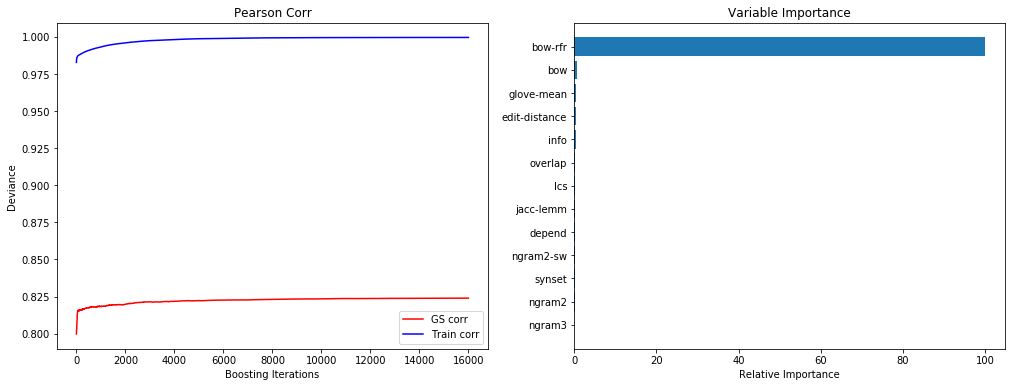

In [38]:
# Select the best features for Gradient Boosting Regressor 
best_features = list(relevant_features.index.drop(['Label']))
# Train the model
params = {'n_estimators': 16000, 'max_depth': 4, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_all[best_features].values, y_all_target)

# Evaluate model performance 
calculate_pearson_corr(model=gbr, features=best_features, model_name="Gradient Boosting Regressor")

# Plot training correlation
test_score = numpy.zeros((params['n_estimators'],), dtype=numpy.float64)
train_score = numpy.zeros((params['n_estimators'],), dtype=numpy.float64)

for i, y_gs_pred in enumerate(gbr.staged_predict(X_gs[best_features])):
    test_score[i] = pearsonr(list(y_gs_target), list(y_gs_pred))[0]
for i, y_all_pred in enumerate(gbr.staged_predict(X_all[best_features])):
    train_score[i] = pearsonr(list(y_all_target), list(y_all_pred))[0]

plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.title('Pearson Corr')
plt.plot(numpy.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='GS corr')
plt.plot(numpy.arange(params['n_estimators']) + 1, train_score, 'b-',
         label='Train corr')
plt.legend()
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = numpy.argsort(feature_importance)
features_vec = numpy.array(best_features)
pos = numpy.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features_vec[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
